# Official realization of the proposed metod

#### May 2024

### Import libraries

In [98]:
from pandas import json_normalize
import pandas as pd
import numpy as np
import copy
import shap
import joblib
import json

from sdmetrics.column_pairs import CorrelationSimilarity, ContingencySimilarity
from sdmetrics.single_table import NewRowSynthesis
from sdmetrics.single_column import MissingValueSimilarity, TVComplement
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CopulaGANSynthesizer, TVAESynthesizer, CTGANSynthesizer
from rdt.transformers.numerical import GaussianNormalizer
import scipy.stats as sts
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [99]:
from synthetic_data_generation import generate_synth_C, generate_synth_R
from evaluation import *
from prediction import *
from modified_WGAN import *

In [100]:
import matplotlib as mpl
#set params for the article
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.labelsize'] = 18

#set params for the notebook
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
# mpl.rcParams['legend.fontsize'] = 10
# mpl.rcParams['axes.labelsize'] = 14

### Import data

In [101]:
data_clf = pd.read_csv('Data/input60NY (C).csv').drop(30)
data_reg = pd.read_csv('Data/input60NY.csv').drop(30)

data_big_reg = pd.read_csv('Data/citiesdataset-NYDcor-4.csv')
data_big_clf = pd.read_csv('Data/citiesdataset-NYDcor-4 (CLASS).csv')

In [102]:
# data_reg = pd.read_csv('Data/superdataset-21.csv')

In [103]:
data_clf = data_clf.drop('avgemployers', axis=1)
data_reg = data_reg.drop('avgemployers', axis=1)
data_big_reg = data_big_reg.drop('avgemployers', axis=1)
data_big_clf = data_big_clf.drop('avgemployers', axis=1)

# data_clf = data_clf.drop('consnewareas', axis=1)
# data_reg = data_reg.drop('consnewareas', axis=1)
# data_big_reg = data_big_reg.drop('consnewareas', axis=1)
# data_big_clf = data_big_clf.drop('consnewareas', axis=1)

In [104]:
temp = data_reg.sample(frac=1)
data_reg = temp.iloc[:-10]
data_reg_test = temp.iloc[-10:]

In [105]:
data_clf_test = data_clf.loc[data_reg_test.index]
data_clf = data_clf.loc[data_reg.index]

In [106]:
# data_reg = data_reg[data_reg['saldo'] > -0.03]

In [107]:
# rostov = pd.read_excel('Data/rostovoblast.xlsx')
# np.corrcoef(rostov.loc[1:4, 'invests'], rostov.loc[:3, 'saldo'])
# np.corrcoef(rostov.loc[6:9, 'invests'], rostov.loc[5:8, 'saldo'])

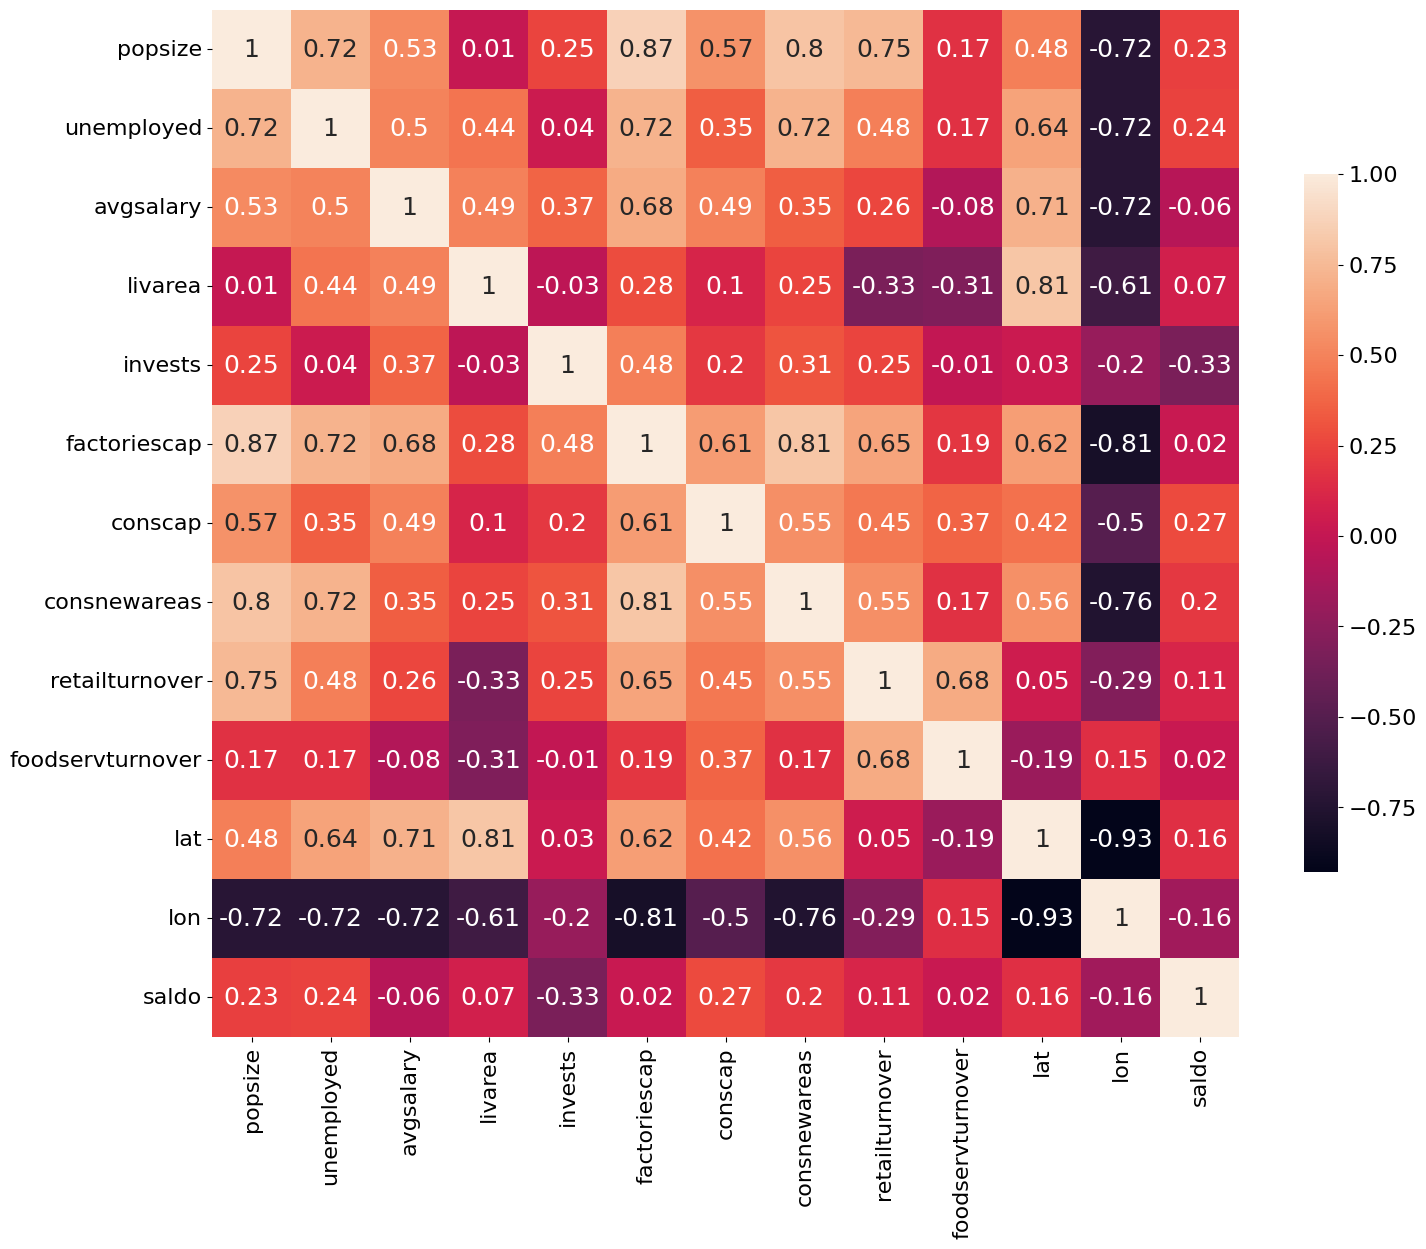

In [108]:
plot_corr(data_reg[data_reg.columns], 'images/corr_small.pdf', save=False)

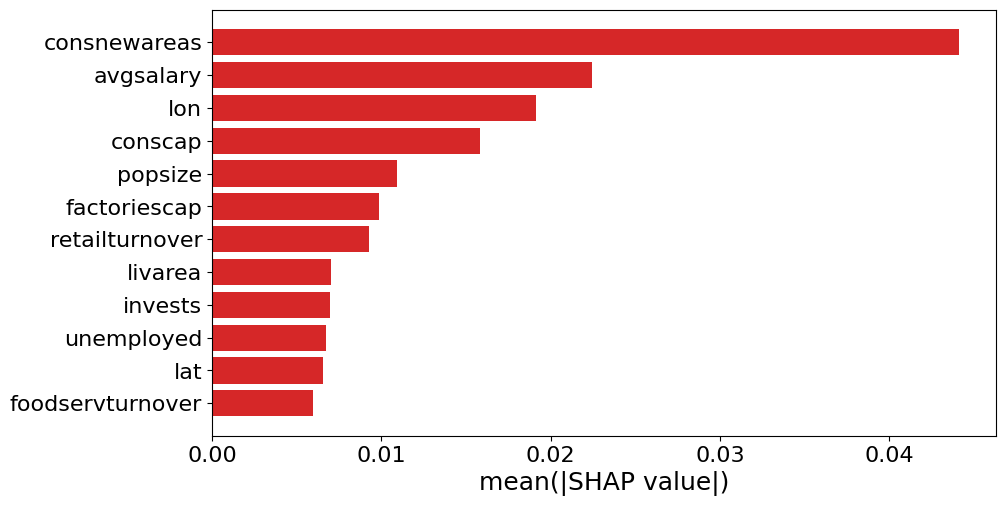

In [109]:
feature_importance(data_reg,  X=data_big_reg[data_reg.columns].drop('saldo', axis=1), y=data_big_reg[data_reg.columns]['saldo'],
                   path='images/feat_import_big.pdf', save=False)

### Normalize data to train generators

In [110]:
transformer_arr_clf = []

for col in data_clf.columns[:-1]:
    transformer = GaussianNormalizer()
    data_clf[col] = transformer.fit_transform(data_clf, column=[col])[col]
    transformer_arr_clf.append(transformer)

In [111]:
transformer_arr_reg = []

for col in data_reg.columns[:-1]:
    transformer = GaussianNormalizer()
    data_reg[col] = transformer.fit_transform(data_reg, column=[col])[col]
    transformer_arr_reg.append(transformer)

### Train generator for classification task

In [14]:
synth_data_clf, synth_metrics_mean_clf = generate_synth_C(data_clf, TVAESynthesizer, n_samples=5000)

In [15]:
synth_metrics_mean_clf

{'corr_sim': 0.944035307225915,
 'TV': 0.9294594594594594,
 'new_row': 0.9990000000000001}

In [16]:
c2st(data_clf, synth_data_clf)

(0.439, 0.7207568848277284)

In [17]:
# Uncomment the code below to draw histograms

# plot_hist(data_clf, synth_data_clf)

### Train generator for regression task

In [18]:
synth_data_reg, synth_metrics_mean_reg = generate_synth_R(data_reg, TVAESynthesizer, n_samples=5000)

In [19]:
synth_metrics_mean_reg

{'corr_sim': 0.9261317116670479, 'new_row': 0.9990000000000001}

In [20]:
c2st(data_reg, synth_data_reg.sample(len(data_reg)))

(0.49121739130434783, 0.5335671218507627)

In [21]:
# Uncomment the code below to draw histograms

# plot_hist(data_reg, synth_data_reg)

In [68]:
# synth_data_clf.to_csv('Data/synth_data_clf.csv', index=False, header=True)
# synth_data_reg.to_csv('Data/synth_data_reg.csv', index=False, header=True)

## Import presave synthetic data

In [112]:
# synth_data_reg = pd.read_csv('Data/synth_data_reg.csv')
# synth_data_clf = pd.read_csv('Data/synth_data_clf.csv')

### Inverse the normalization

In [113]:
for i, col in enumerate(synth_data_clf.columns[:-1]):
        synth_data_clf[col] = transformer_arr_clf[i].reverse_transform(synth_data_clf)[col]
        
for i, col in enumerate(data_clf.columns[:-1]):
        data_clf[col] = transformer_arr_clf[i].reverse_transform(data_clf)[col]
        
for i, col in enumerate(data_reg.columns[:-1]):
        data_reg[col] = transformer_arr_reg[i].reverse_transform(data_reg)[col]
        
for i, col in enumerate(synth_data_reg.columns[:-1]):
        synth_data_reg[col] = transformer_arr_reg[i].reverse_transform(synth_data_reg)[col]

In [25]:
def plot_significance_ks(data_clf, synth_data_clf, data_reg, synth_data_reg, path='pvalue', save=False):
    plt.subplots(figsize=(8, 7))
    plt.bar(np.arange(len(data_clf.columns)), ks_test(data_clf, synth_data_clf.sample(len(data_clf))), color='tab:blue', alpha=0.7, label='classification')
    plt.bar(np.arange(len(data_reg.columns)), ks_test(data_reg, synth_data_reg.sample(len(data_reg))), color='tab:red', alpha=0.7, label='regression')

    plt.plot([-1, 14], [0.05, 0.05], color='black', label='significance level')

    # plt.xlabel('column index')
    # plt.xticks(ticks=np.arange(len(data_clf.columns)))
    plt.xticks(ticks=np.arange(len(data_clf.columns)), labels=list(data_reg.columns), rotation=90)
    plt.ylabel('p-value')
    plt.legend()

    plt.tight_layout(pad=0.5)
    if save:
        plt.savefig(path, dpi=300)

    plt.show()  

In [26]:
synth_data_clf_sam = pd.DataFrame(np.zeros(data_clf.shape), columns=data_clf.columns)

for _ in range(31):
    synth_data_clf_sam = synth_data_clf_sam + synth_data_clf.sample(len(data_clf)).reset_index(drop=True)
    
synth_data_clf_sam = synth_data_clf_sam / 31

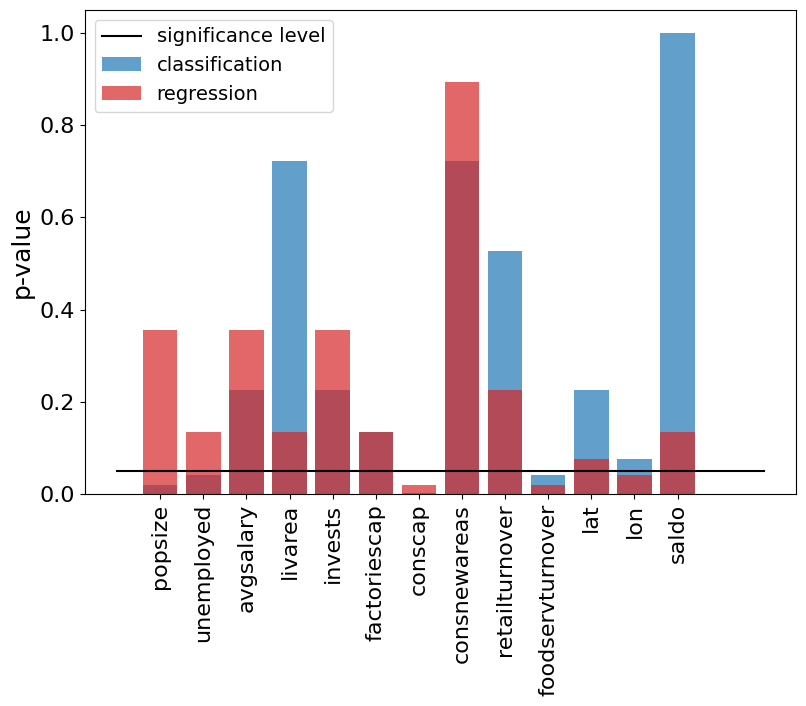

In [27]:
plot_significance_ks(data_clf, synth_data_clf, data_reg, synth_data_reg, path='images/pvalue_CopulaGAN.pdf', save=True)

### Train classifier

In [28]:
# model_clf, errors_clf = classification(data_big_clf, data_clf, n_trials=30, test_size=0.2)
# model_clf, errors_clf = classification(data_clf, data_clf, n_trials=30, test_size=0.2)
model_clf, errors_clf = classification(synth_data_clf, data_clf, n_trials=30, test_size=0.2)

[I 2024-07-08 11:56:45,810] A new study created in memory with name: no-name-fbfcc993-0227-49ca-8eb9-1f1b726e525b
[I 2024-07-08 11:56:47,405] Trial 0 finished with value: 0.9349643223805462 and parameters: {'n_estimators': 200, 'max_depth': 3}. Best is trial 0 with value: 0.9349643223805462.
[I 2024-07-08 11:56:48,275] Trial 1 finished with value: 0.9098730325591051 and parameters: {'n_estimators': 300, 'max_depth': 1}. Best is trial 0 with value: 0.9349643223805462.
[I 2024-07-08 11:56:49,436] Trial 2 finished with value: 0.9325938260893322 and parameters: {'n_estimators': 150, 'max_depth': 3}. Best is trial 0 with value: 0.9349643223805462.
[I 2024-07-08 11:56:50,583] Trial 3 finished with value: 0.9313930629358678 and parameters: {'n_estimators': 200, 'max_depth': 2}. Best is trial 0 with value: 0.9349643223805462.
[I 2024-07-08 11:56:52,077] Trial 4 finished with value: 0.9349643223805462 and parameters: {'n_estimators': 200, 'max_depth': 3}. Best is trial 0 with value: 0.934964322

### Presave model

In [67]:
# joblib.dump(model_clf, "model_clf.pkl") 
# np.save('errors_clf.npy', errors_clf) 

In [114]:
# model_clf = joblib.load("model_clf.pkl")
# errors_clf = np.load('errors_clf.npy', allow_pickle='TRUE').item()

In [31]:
errors_clf

{'F1 train': 1.0,
 'F1 val': 0.9274269557021678,
 'F1 real test': 0.972972972972973,
 'F1 CV': 0.9383323503147173,
 'roc_auc_score': 0.9856204619887888}

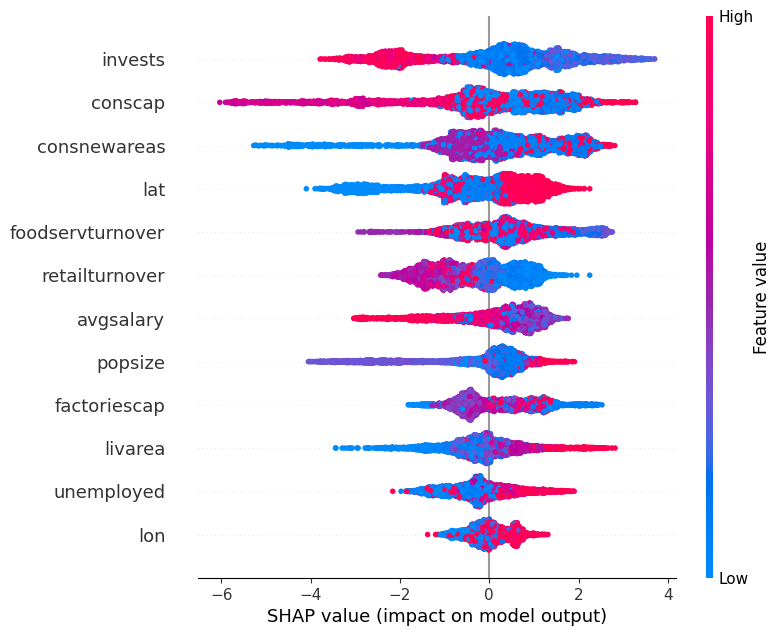

In [73]:
plot_shap(model_clf, data_clf, synth_data_clf, path='images/feature_importance.pdf', save=False)

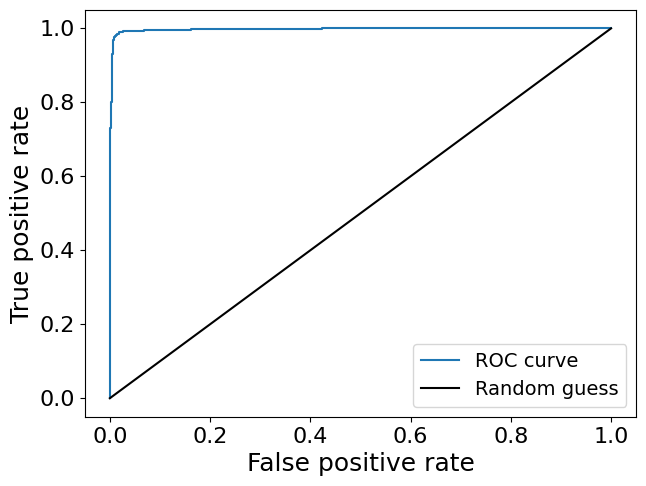

In [33]:
plot_roc_curve(model_clf, synth_data_clf, path='images/roc_curve.pdf', save=False)

### Enhance regression syntehtic (OPTIONAL)

In [34]:
# reg_NN, reg_losses = train_reg_NN(synth_data_reg, batch_size=64, epochs=2000)
# synth_data_reg_enh, losses = train_modified_WGAN(synth_data_reg, reg_NN, epochs=2000)

In [35]:
# plot_losses(losses)

In [36]:
# plot_hist_kde(synth_data_reg_enh, synth_data_reg)

### Train regressor

In [37]:
# model_reg, errors_reg = regression(synth_data_reg_enh, data_reg, n_trials=30, test_size=0.2) #enhanced synth small cities
# model_reg, errors_reg = regression(data_big_reg, data_reg, n_trials=30, test_size=0.2) #big cities
# model_reg, errors_reg = regression(data_reg, data_reg, n_trials=30, test_size=0.2) #small cities
model_reg, errors_reg = regression(synth_data_reg, data_reg, n_trials=30, test_size=0.2) #synth small cities

[I 2024-07-08 11:57:31,594] A new study created in memory with name: no-name-ff79059e-14af-493e-a132-eb5cf3db9fe1
[I 2024-07-08 11:57:32,336] Trial 0 finished with value: -1.3556834387040616e-05 and parameters: {'n_estimators': 150, 'max_depth': 2}. Best is trial 0 with value: -1.3556834387040616e-05.
[I 2024-07-08 11:57:33,099] Trial 1 finished with value: -1.1842998419817153e-05 and parameters: {'n_estimators': 100, 'max_depth': 3}. Best is trial 0 with value: -1.3556834387040616e-05.
[I 2024-07-08 11:57:33,806] Trial 2 finished with value: -1.1842998419817153e-05 and parameters: {'n_estimators': 100, 'max_depth': 3}. Best is trial 0 with value: -1.3556834387040616e-05.
[I 2024-07-08 11:57:35,095] Trial 3 finished with value: -1.2139629360849653e-05 and parameters: {'n_estimators': 250, 'max_depth': 2}. Best is trial 0 with value: -1.3556834387040616e-05.
[I 2024-07-08 11:57:36,239] Trial 4 finished with value: -1.0890584463419423e-05 and parameters: {'n_estimators': 150, 'max_depth'

## Presave model

In [66]:
# joblib.dump(model_reg, "model_reg.pkl") 
# np.save('errors_reg.npy', errors_reg) 

In [115]:
# model_reg = joblib.load("model_reg.pkl")
# errors_reg = np.load('errors_reg.npy', allow_pickle='TRUE').item()

In [40]:
errors_reg

{'MAPE train': 2.2807299488222106,
 'MAPE val': 2.3055301721226793,
 'MAPE real test': 0.8932379856765607,
 'MAE CV': 78.08362170626393,
 'MSE x 10e-4': 0.4052570295102354}

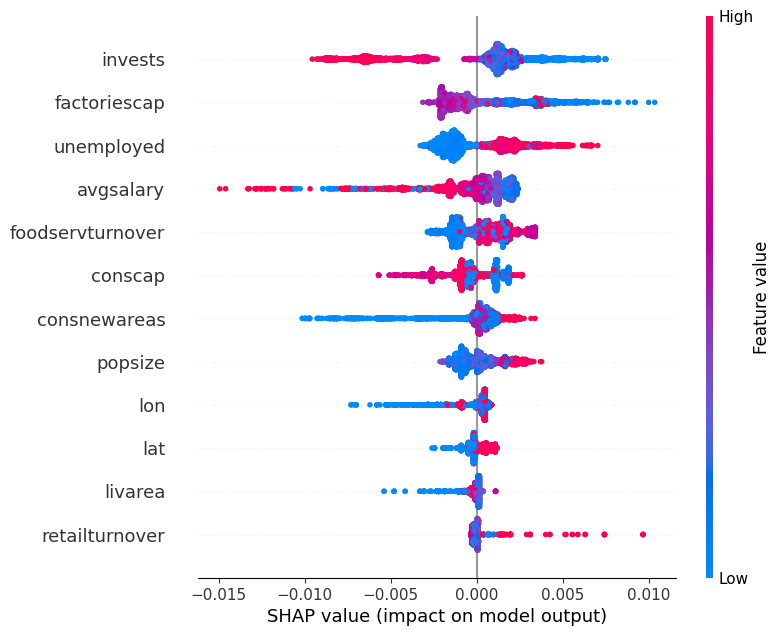

In [74]:
plot_shap(model_reg, data_reg, synth_data_reg, path='images/feature_importance_reg.pdf', save=False)

### Correct prediction

In [125]:
prediction = correct_prediction(model_clf, model_reg, data_reg)

### Quantitative Evaluation

Ошибка MSE в $10^{-4}$

In [126]:
mean_squared_error(data_reg['saldo'], prediction) * 10000

1.1430874393621357

Ошибка MAE в людях

In [127]:
mean_absolute_error(data_reg['saldo'], prediction) * 26466

164.0379205112246

Ошибка MAPE в людях

In [128]:
mean_absolute_percentage_error(data_reg['saldo']*26466, prediction*26466)

0.6572540128347073

### Qualitative Evaluation

In [129]:
import statsmodels.api as sm

In [138]:
def plot_qq_with_axis(data_test, prediction, save=False, norm=26466):
    plt.plot(data_test['saldo']*norm, data_test['saldo']*norm, color='tab:red', zorder=2, label='Identity line')
    plt.scatter(data_test['saldo']*norm, prediction*norm ,zorder=3, color='tab:blue')
    
    #Confidence interval
    lr = LinearRegression()
    lr.fit(data_test['saldo'].values.reshape(-1, 1)*norm, prediction.reshape(-1, 1)*norm)
    plt.plot(data_test['saldo']*norm, lr.intercept_ + lr.coef_[0] * data_test['saldo']*norm, zorder=1, color='green', label='OLS', alpha=0.8)
    
    t_crit = sts.t.ppf(1 - 0.05/2, df=len(prediction) - 2)
    x = sorted(data_test['saldo']*norm)
    # sigma = np.std(prediction*norm)
    sigma = np.sqrt(sum((prediction*norm - data_test['saldo']*norm)**2) / (len(prediction)-2))
    x_bar = np.mean(x)
    plt.fill_between(x, lr.intercept_ + lr.coef_[0] * x - t_crit * sigma * np.sqrt(  1/len(x) + (x - x_bar)**2/((x-x_bar)**2).sum()),
                 lr.intercept_ + lr.coef_[0] * x + t_crit * sigma * np.sqrt(  1/len(x) + (x - x_bar)**2 / ((x-x_bar)**2).sum()), 
                 color = 'green', alpha = 0.1, label = '95% CI', linestyle='-')


    plt.xlabel('True')
    plt.ylabel('Prediction')
    
    plt.axhline(0., c='k', linewidth=0.7, zorder=1)
    plt.axvline(0., c='k', linewidth=0.7, zorder=1)

    plt.legend()
    
    plt.tight_layout(pad=0.5)
    
    if save:
        plt.savefig('images/qq_plot.pdf', dpi=300)
        
    plt.show()

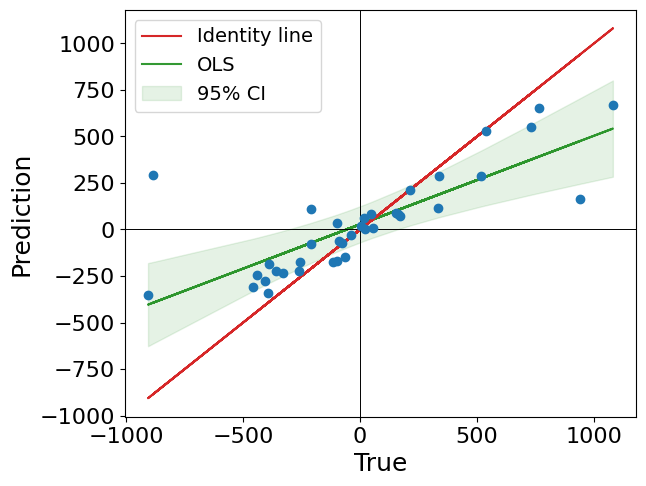

In [139]:
plot_qq_with_axis(data_reg, prediction, save=False)

In [49]:
# prediction = correct_prediction(model_clf, model_reg, synth_data_reg)
# plot_qq(synth_data_reg, prediction)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(synth_data_reg.drop('saldo', axis=1), synth_data_reg['saldo'], test_size=0.2, shuffle=True)

In [141]:
model_test = XGBRegressor()

model_test.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

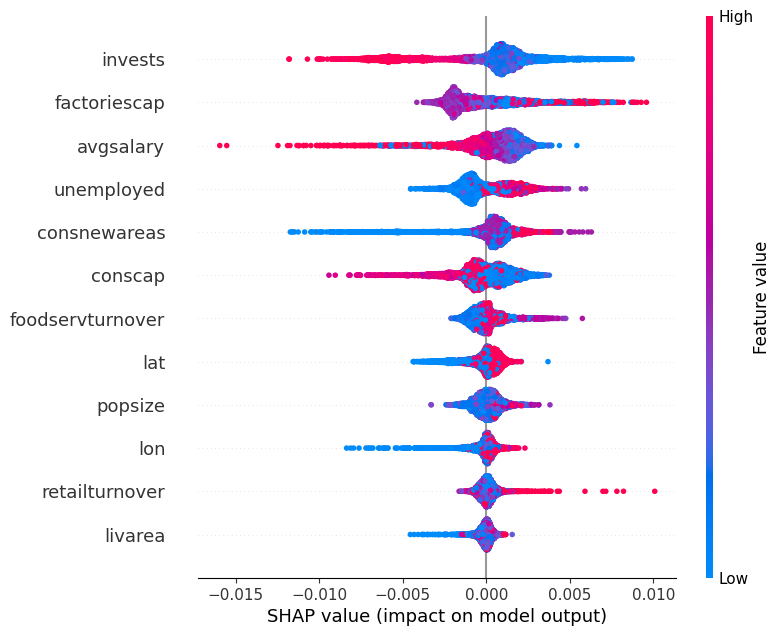

In [142]:
plot_shap(model_test, data_reg, synth_data_reg, path='images/feature_importance_reg.pdf', save=False)

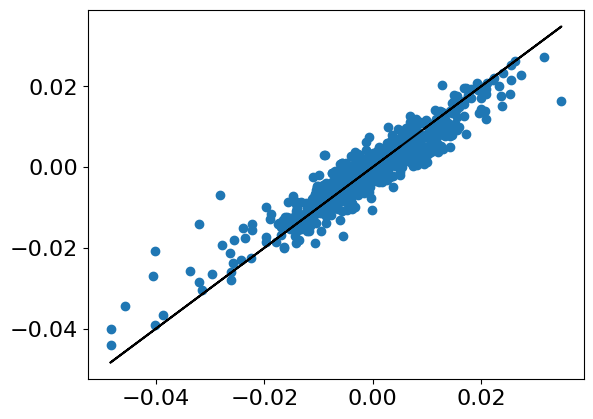

In [143]:
plt.scatter(y_test, model_test.predict(X_test))
plt.plot(y_test, y_test, color='black')

plt.show()

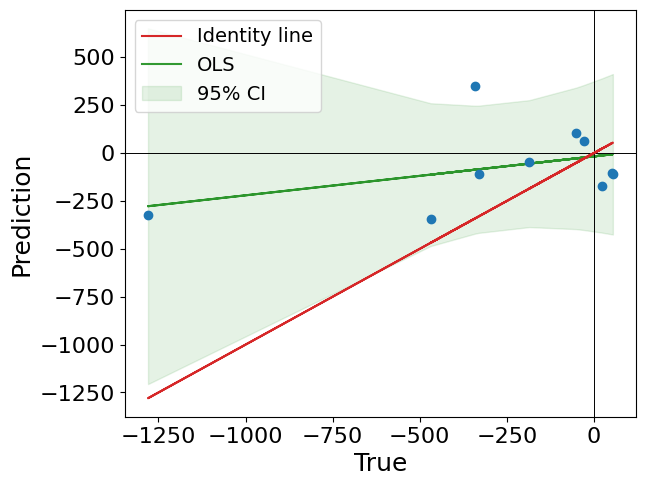

In [144]:
plot_qq_with_axis(data_reg_test, model_test.predict(data_reg_test.drop('saldo', axis=1)), save=False)

In [145]:
pred_class = model_clf.predict(data_clf.drop('saldo', axis=1))
prediction = np.abs(model_test.predict(data_reg.drop('saldo', axis=1)))
prediction[np.where(pred_class == 0)[0]] = prediction[np.where(pred_class == 0)[0]] * (-1)

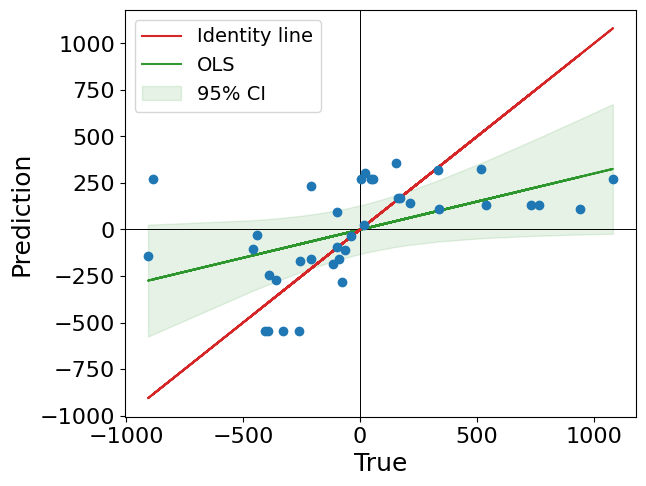

In [146]:
plot_qq_with_axis(data_reg, prediction, save=False)